In [2408]:
import numpy as np
import pandas as pd
import random
import statsmodels.api as sm

from scipy import stats
from scipy.stats import shapiro
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import probplot

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#### Пути к директориям и файлам

In [2409]:
TRAIN_DATASET_PATH = 'project/course_project_train.csv'
TEST_DATASET_PATH = 'project/course_project_test.csv'

### Постановка задачи

**Задача**

На основании имеющихся данных о клиентах банка требуется построить модель для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1($\beta$ = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)


#### Загрузка данных

In [2410]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()
df_test = pd.read_csv(TEST_DATASET_PATH)

In [2411]:
df_train.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

### Обзор данных

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

#### Обзор обучающего датасета

In [2412]:
df_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [2413]:
df_train.shape

(7500, 17)

In [2414]:
df_test.shape

(2500, 16)

#### Имеем:
 - 4 категориальных признака;
 - 12 количественных признаков;
 - 1 целевая переменнная типа - int

Посмотрим на данные используя основные статистики

In [2415]:
df_train.describe(include='all')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7500,5.943000e+03,7129,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7500,7500,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
unique,4,NaN,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,2,NaN,NaN,NaN,NaN,NaN
top,Home Mortgage,NaN,10+ years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,debt consolidation,Short Term,NaN,NaN,NaN,NaN,NaN
freq,3637,NaN,2332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5944,5556,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.366392e+06,NaN,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,NaN,NaN,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,NaN,8.453392e+05,NaN,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,NaN,NaN,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,NaN,1.645970e+05,NaN,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,NaN,8.443410e+05,NaN,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,NaN,NaN,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,NaN,1.168386e+06,NaN,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,NaN,NaN,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,NaN,1.640137e+06,NaN,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,NaN,NaN,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000


Определим в каких признаках были пропуски в данных

In [2416]:
df_train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

В признаках Current Loan Amount, Credit Score, Maximum Open Credit присутствуют выбросы с правой стороны. В признаке 'Months since last delinquent' много пропусков (больше половины выборки). Остальные данные при первом приближении не выбиваются из "нормальности".

- присвою целевой переменной имя

In [2417]:
target_name = 'Credit Default'

- Разобью исходный датасет на два - в котором произошел не платёж по кредиту (целевая переменная равна 1) и на датасет в котором с платежами всё хорошо (целевая переменная равна 0), с целью определить возможные "разности", которые лежат на поверхности.

In [2418]:
tmp_credit_default = df_train.loc[(df_train[target_name] == 1)]
#tmp_credit_default.head()

In [2419]:
tmp_no_credit_default = df_train.loc[(df_train[target_name] == 0)]
#tmp_no_credit_default.head()

- выведем основные статистики обоих датасетов

In [2420]:
tmp_no_credit_default.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,4.359000e+03,5387.000000,5387.000000,5387.000000,5.387000e+03,5387.000000,2436.000000,5377.000000,5.387000e+03,5.387000e+03,5387.000000,4359.000000,5387.0
mean,1.418047e+06,0.025988,11.042138,18.408168,1.088422e+06,0.163727,34.656814,0.116794,1.640219e+07,2.937194e+05,18176.425469,723.577885,0.0
std,8.845096e+05,0.256502,4.871796,6.959349,1.890526e+07,0.480127,21.516233,0.344130,3.669223e+07,3.359989e+05,11917.013432,25.412545,0.0
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,590.000000,0.0
25%,8.663525e+05,0.000000,8.000000,13.700000,2.895860e+05,0.000000,17.000000,0.000000,1.798060e+05,1.145035e+05,9894.500000,713.000000,0.0
50%,1.225747e+06,0.000000,10.000000,17.100000,4.937460e+05,0.000000,32.000000,0.000000,3.145340e+05,2.092850e+05,15939.000000,732.000000,0.0
75%,1.709572e+06,0.000000,14.000000,22.000000,8.233610e+05,0.000000,50.000000,0.000000,5.510780e+05,3.629095e+05,23717.500000,742.000000,0.0
max,1.014934e+07,7.000000,43.000000,51.900000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,751.000000,0.0


In [2421]:
tmp_credit_default.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,1.584000e+03,2113.000000,2113.000000,2113.000000,2.113000e+03,2113.000000,983.000000,2109.000000,2113.000000,2.113000e+03,2113.000000,1584.000000,2113.0
mean,1.224243e+06,0.040700,11.357312,18.086228,5.798982e+05,0.185991,34.781282,0.118065,326651.044013,2.799256e+05,18666.352106,2327.548611,1.0
std,7.077733e+05,0.306572,4.996364,7.244804,5.517541e+05,0.542644,22.121493,0.354961,186027.080635,2.659432e+05,11947.197046,2787.985441,0.0
min,1.940280e+05,0.000000,2.000000,4.500000,0.000000e+00,0.000000,0.000000,0.000000,21472.000000,0.000000e+00,0.000000,585.000000,1.0
25%,7.726730e+05,0.000000,8.000000,13.100000,2.562560e+05,0.000000,15.000000,0.000000,181610.000000,1.124610e+05,10534.000000,704.000000,1.0
50%,1.055916e+06,0.000000,11.000000,16.700000,4.420900e+05,0.000000,33.000000,0.000000,290576.000000,2.101020e+05,16390.000000,730.500000,1.0
75%,1.493894e+06,0.000000,14.000000,21.500000,7.279580e+05,0.000000,52.000000,0.000000,444708.000000,3.536470e+05,24057.000000,6162.500000,1.0
max,8.710740e+06,5.000000,42.000000,57.700000,6.639358e+06,5.000000,86.000000,4.000000,788634.000000,3.944514e+06,104036.000000,7510.000000,1.0


всего было 2113 клиентов банка допустивших неплатеж по кредиту, что составляет 28% от общего кол-ва клиентов учебного датасета.

Из первичного анализа двух датасетов можно заключить следующее:
 1. Диапазоны квартильных значений совпадают до значений, либо отличаются незначительно в следующих признаках - Tax Liens, Number of Open Accounts, Number of Credit Problems, Bankruptcies, Current Credit Balance. Что при первом приближении может свидетельствовать о слабом воздействии этих признаков на целевую переменную.
 2. В "дефолтном" датасете у признака Credit Score присутствуют выбросы с правой стороны, необходимо изучить и проанализировать основные статистики после "исправлений".
 3. В "дефолтном" датасете у признака  Monthly Debt значения соответствующих квартилей выше чем у датасета не имеющего просрочек, что логично, так как свидетельствует о "перегруженности" кредитом, а у признаков Annual Income, Maximum Open Credit, Current Loan Amount значения соответствующих квартилей ниже чем у датасета не имеющего просрочек, что в свою очередь очевидно, так как признак Annual Income (годовой доход) чем выше тем "благоприятнее" для погашения кредита, признак Maximum Open Credit (наибольший открытый кредит) чем выше, тем "состоятельнее" клиент получающий кредит. Отдельно стоит рассмотреть признак Current Loan Amount (текущая сумма кредита), потому как:
  а) показатели квартилей выше у "не дефолтного" датасета, что странно, потому как ожидаешь увидеть противоположное - сумма задолженности выше и вероятность наступления дефолта выше.
  б) в признаке у "не дефолтного" датасета присутствует "странное" число "1.000000e+08", выбивающееся на порядок от медианного по выборке. Возможно, что после обработки этих значений решится коллизия обозначенная в пункте а).
 4. В признаке Annual Income "логично" квартильные значения у "не дефолтного" датасета выше, но в признаке большое количество пропусков, что не даёт возможности утверждать о закономерности. Необходимо заполнить пропуски и вернуться к анализу.

### Обработка пропусков и предельных значений.

### признак 'Credit Score'

In [2422]:
tmp_credit_default['Credit Score'].isna().sum()

529

In [2423]:
tmp_no_credit_default['Credit Score'].isna().sum()

1028

In [2424]:
# tmp_credit_default['Credit Score'].unique()

Присутствуют выбросы в районе 7000. Посмотрю распределение на гистограмме.

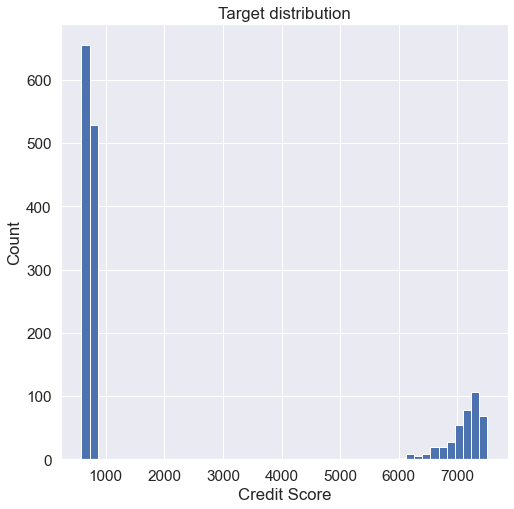

In [2425]:
plt.figure(figsize = (8, 8))

tmp_credit_default['Credit Score'].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Credit Score')

plt.title('Target distribution')
plt.show()

- из анализа видно, что в признаке присутствуют данные с правой стороны значения которых "ошибочно" умножены на 10. Вернём им корректные значения.

In [2426]:
condition = tmp_credit_default['Credit Score'] > 5000

tmp_credit_default.loc[condition, 'Credit Score'] = tmp_credit_default.loc[condition, 'Credit Score'] / 10
tmp_credit_default['Credit Score'].describe()

count    1584.000000
mean      710.480429
std        32.094906
min       585.000000
25%       694.000000
50%       720.000000
75%       735.000000
max       751.000000
Name: Credit Score, dtype: float64

In [2427]:
tmp_credit_default['Credit Score'].count()

1584

In [2428]:
tmp_credit_default['Credit Score'].isna().sum()

529

- заменим некорректные данные в признаке 'Credit Score' в исходном датасете

In [2429]:
# condition = df_train['Credit Score'] > 5000
# df_train.loc[condition, 'Credit Score'] = df_train.loc[condition, 'Credit Score'] / 10
# df_train['Credit Score'].describe()

- посмотрим на распределение этого признака после внесённых изменений в обоих датасетах.

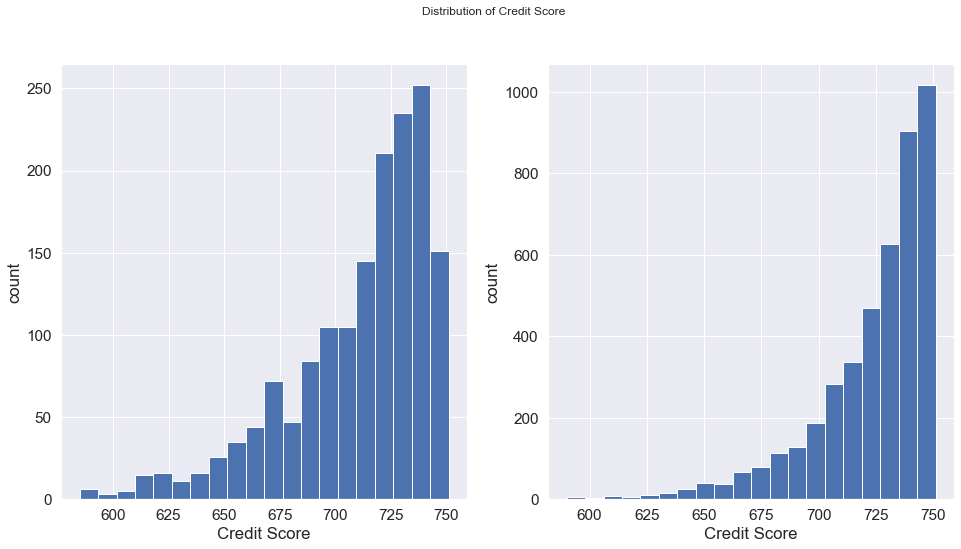

In [2430]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
tmp_credit_default['Credit Score'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('Credit Score')

plt.subplot(122)
tmp_no_credit_default['Credit Score'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('Credit Score')

plt.suptitle('Distribution of Credit Score')
plt.show()

Распределения похожи. Есть заметное смещение в "дефолтном" датасете в левую сторону.

In [2431]:
# tmp_credit_default['Credit Score'].describe()

In [2432]:
# tmp_no_credit_default['Credit Score'].describe()

- В "не дефолтном" датасете признак 'Credit Score' имеет квартильные значения больше чем в "дефолтном" датасете.
Чем заполнить пропуски в этом признаке явно не обнаружил, за исключением того факта, что количество пропусков в признаке такое же как и в признаке 'Annual Income'. Обработывать пропуски в этих признаках, скорее всего, придется из одного "источника". 

### признак 'Current Loan Amount'

In [2433]:
feat = 'Current Loan Amount'

In [2434]:
# tmp_no_credit_default['Current Loan Amount'].describe()

Посмотрю на правую сторону признака.

In [2435]:
# tmp_no_credit_default.loc[tmp_no_credit_default[feat] > tmp_no_credit_default[feat].quantile(.835)][feat].unique()

Из всего многообразия значений выделяются значения признака все "9" - "99999999". 

Рассмотрю значения целевой переменной, где признак 'Current Loan Amount' принимает это значение.

In [2436]:
# df_train.loc[df_train[feat]== 99999999.].shape == tmp_no_credit_default.loc[tmp_no_credit_default[feat]== 99999999.].shape

In [2437]:
# tmp_credit_default.loc[tmp_credit_default[feat]== 99999999.].shape

- Видим, что хоть и значение этого признака (текущая сумма кредита) максимально, но ни одного дефолтного клиента это не добавляет. Следовательно, можно сделать вывод, что это возможно так называемый фактор "переноса", возникающий при "не возможном" значении в ячейке (памяти компьютера, выделенного под это значение) или, другими словами, при возникновении в этой ячейке отрицательного значения, а это возможно при погашении кредита или наличия на кредитном счету суммы больше, чем задолженность. Заменим эти "девятки" нулевым значением.

In [2438]:
# condition = df_train[feat] == 99999999.
# df_train.loc[condition, 'Current Loan Amount'] = df_train.loc[condition, 'Current Loan Amount'] * 0
# df_train['Current Loan Amount'].describe()

- Сделаем тоже самое в "не дефолтном" датасете

In [2439]:
# condition = tmp_no_credit_default[feat] == 99999999.
# tmp_no_credit_default.loc[condition, 'Current Loan Amount'] = tmp_no_credit_default.loc[condition, 'Current Loan Amount'] * 0

### признак 'Maximum Open Credit'

- признак имеет "неадекватные" значения с правой стороны. Обработаем 2,5% значений справой стороны, заменив их медианными значениями, а слева обработаем нулевые значения.

In [2440]:
feat = 'Maximum Open Credit'

In [2441]:
# max_open_credit_max_value = np.quantile(df_train['Maximum Open Credit'], q=0.975)

In [2442]:
# df_train.loc[df_train['Maximum Open Credit'] == 0].shape

In [2443]:
# max_open_credit_min_value = np.quantile(df_train['Maximum Open Credit'], q=0.01)
# max_open_credit_min_value

In [2444]:
# condition = (df_train['Maximum Open Credit'] > max_open_credit_max_value) | (df_train['Maximum Open Credit'] == 0)
# df_train[condition].head().sort_values(by='Maximum Open Credit')

In [2445]:
#condition = (df_train['Maximum Open Credit'] < max_open_credit_min_value) #| ()
#df_train[condition].head().sort_values(by='Maximum Open Credit')

In [2446]:
# df_train.loc[condition,'Maximum Open Credit'] = df_train['Maximum Open Credit'].median()
# df_train['Maximum Open Credit'].describe()

In [2447]:
# plt.figure(figsize = (16, 8))

# df_train['Maximum Open Credit'].hist(bins=30)
# plt.ylabel('Count')
# plt.xlabel('Maximum Open Credit')

# plt.title('Target distribution')
# plt.show()

Сейчас распределение признака приближенно нопоминает нормальное распределение.

In [2448]:
# df_train['Maximum Open Credit'].describe()

## Обработка пропусков

Пропуски наблюдаются в следующих признаках Annual Income, Years in current job, Months since last delinquent, Bankruptcies и в Credit Score. 

рассмотрим признак 'Annual Income' в разрезе разных признаков не имеющих пропусков в начальных данных с целью определить максимально "похожих" клиентов и заполнения пропусков.

- признак 'Current Loan Amount' (текущая сумма кредита)

In [2449]:
# df_cat_сurrent_loan_amount = df_train.groupby('Current Loan Amount', as_index=False).median()[['Current Loan Amount', 'Annual Income']]
# df_cat_сurrent_loan_amount = pd.DataFrame(df_cat_сurrent_loan_amount)

# df_cat_сurrent_loan_amount.sort_values(by='Current Loan Amount').head(10)

текущие суммы кредита схожие, но годовой доход имеет широкий разброс. По этой причине для закрытия пропусков в 'Annual Income' признак 'Current Loan Amount' не подходит.

- признак 'Maximum Open Credit' (наибольший открытый кредит)

In [2450]:
# df_cat_max_cr = df_train.groupby('Maximum Open Credit', as_index=False).median()[['Maximum Open Credit', 'Annual Income']]
# df_cat_max_cr = pd.DataFrame(df_cat_max_cr)

# df_cat_max_cr.sort_values(by='Maximum Open Credit').head(10)

'наибольший открытый кредит' схож, но годовой доход имеет широкий разброс. По этой же причине для закрытия пропусков в 'Annual Income' признак 'Maximum Open Credit' не подходит.

- признак 'Current Credit Balance' (текущий кредитный баланс)

In [2451]:
# df_cat_cur_cr_bal = df_train.groupby('Current Credit Balance', as_index=False).median()[['Current Credit Balance', 'Annual Income']]
# df_cat_cur_cr_bal = pd.DataFrame(df_cat_cur_cr_bal)

# df_cat_cur_cr_bal.sort_values(by='Current Credit Balance').head(10)

годовой доход имеет широкий разброс при близости значений 'текущий кредитный баланс'. По этой же причине для закрытия пропусков в 'Annual Income' признак 'Current Credit Balance' не подходит.

- признак 'Credit Score' (кредитный рейтинг). Признаки "схожи" в кол-ве пропусков в начальных данных. Можно предположить прямую зависимость между ними. Смотрим.

In [2452]:
# df_cat_credit_score = df_train.groupby('Credit Score', as_index=False).median()[['Credit Score', 'Annual Income']]
# df_cat_credit_score = pd.DataFrame(df_cat_credit_score)
# df_tmp_head = df_cat_credit_score.sort_values(by='Credit Score').head(10)
# df_tmp_head

In [2453]:
# df_tmp_tail = df_cat_credit_score.sort_values(by='Credit Score').tail(10)

In [2454]:
# df_tmp_head.describe()

In [2455]:
# df_tmp_tail.describe()

Из последних двух таблиц делаю вывод, о невозможности воспользоваться признаком Credit Score для заполнения пропусков в 'годовом доходе' - "75"-ая квартиль в группе малого кредитного рейтинга на 50%(почти) превосходит 75-ую квартиль группы высого кредитного рейтинга, а максимум превосходит в два раза. 

Самый представительный (в плане разнообразия) признак - 'Purpose' (цель кредита). Этот признак категориальный и его можно рассмотреть в качестве источника данных для 'Annual Income' исходя из того предположения, что люди обладающие одинаковым доходом могут иметь и одинаковые траты или одинаковые запросы в жизни.

- Итак, рассмотрим признак 'Annual Income' в разрезе признака 'Purpose' (цель кредита)

In [2456]:
# df_cat_purpose = df_train.groupby('Purpose', as_index=False).median()[['Purpose', 'Annual Income']]
# df_cat_purpose = pd.DataFrame(df_cat_purpose)

# df_cat_purpose

- заполним имеющиеся пропуски в агрегированой таблице медианным значением.

In [2457]:
# df_cat_purpose['Annual Income'].median()

In [2458]:
# df_cat_purpose['Annual Income'] = df_cat_purpose['Annual Income'].fillna(df_cat_purpose['Annual Income'].median())
# df_cat_purpose

- переминуем столбец, дабы не иметь в итоговом два одинаковых.

In [2459]:
# df_cat_purpose.rename(columns={'Annual Income' : 'median_purpose_annual_income'}, inplace=True)
# df_cat_purpose.sort_values(by='median_purpose_annual_income')

- сделаем слияние с основным датасетом.

In [2460]:
# df_train = df_train.merge(df_cat_purpose, on=['Purpose'])
# df_train.head()

- заменим пропуски в исходных данных признака 'Annual Income' медианным значением годового дохода "групп по интересам" (целей кредита) 

In [2461]:
# df_train['Annual Income'] = df_train['Annual Income'].fillna(df_train['median_purpose_annual_income'])

In [2462]:
# df_train['Annual Income'].isna().value_counts()

### признак 'Years in current job'

изучу попарное распределение признаков с изучаемым, для выявление взаимного влияния.

In [2463]:
# df_cat_annual_income = df_train.groupby('Years in current job', as_index=False).median()[['Years in current job', 'Annual Income']]
# df_cat_annual_income = pd.DataFrame(df_cat_annual_income)

# df_cat_annual_income.sort_values(by='Annual Income').head(10)

In [2464]:
# df_train['Years in current job'].isna().sum()

In [2465]:
# df_train['Years in current job'].value_counts().sort_values()

In [2466]:
# tmp = df_train.loc[df_train['Years in current job'].isna()]
# tmp.head()

In [2467]:
# tmp['Home Ownership'].value_counts()

In [2468]:
# tmp['Purpose'].value_counts()

In [2469]:
# df_train.loc[df_train['Purpose'] == 'debt consolidation', 'Years in current job'].value_counts()

In [2470]:
# df_train.groupby('Purpose', as_index=False).mean()['Annual Income']

In [2471]:
# tmp[target_name].value_counts()

In [2472]:
# df_num_features = tmp.select_dtypes(include=['float64', 'float32', 'float16'])
# df_num_features

In [2473]:
# df_num_features.hist(figsize=(16, 16), bins=20, grid=False);

- В признаке 'Years in current job', где есть пропуски нет выраженной причины этого пропуска. Составим массив уникальных значений и случайный образом заполним эти пропуски.

In [2474]:
dict_tmp = df_train.loc[df_train['Years in current job'].isna() != True, 'Years in current job'].unique()
dict_tmp

array(['10+ years', '8 years', '6 years', '7 years', '5 years', '1 year',
       '< 1 year', '4 years', '3 years', '2 years', '9 years'],
      dtype=object)

In [2475]:
df_train['Years in current job'] = df_train['Years in current job'].fillna(random.choice(dict_tmp))
df_test['Years in current job'] = df_test['Years in current job'].fillna(random.choice(dict_tmp))

In [2476]:
df_train['Years in current job'].isna().sum()

0

In [2477]:
df_test['Years in current job'].isna().sum()

0

### признак 'Bankruptcies'

In [2478]:
df_train['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [2479]:
tmp_no_credit_default['Bankruptcies'].value_counts()

0.0    4782
1.0     569
2.0      20
3.0       5
4.0       1
Name: Bankruptcies, dtype: int64

In [2480]:
tmp_credit_default['Bankruptcies'].value_counts()

0.0    1878
1.0     217
2.0      11
3.0       2
4.0       1
Name: Bankruptcies, dtype: int64

- Распределение признака в дефолтном и не дефолтном датасете одинаково. Мода признака значение 0.

In [2481]:
tmp_no_credit_default['Bankruptcies'].describe()

count    5377.000000
mean        0.116794
std         0.344130
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: Bankruptcies, dtype: float64

In [2482]:
tmp_credit_default['Bankruptcies'].describe()

count    2109.000000
mean        0.118065
std         0.354961
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: Bankruptcies, dtype: float64

- Значение квартилей в дефолтном и не дефолтном датасете равны. Обнуляем пропуски, так как это мода этого признака.

In [2483]:
# df_train['Bankruptcies'].fillna(0, inplace=True)
# tmp_no_credit_default['Bankruptcies'].fillna(0, inplace=True)
# tmp_credit_default['Bankruptcies'].fillna(0, inplace=True)

In [2484]:
# df_train.isna().sum()

### признак 'Months since last delinquent'

- признак имеет очень много пропусков. Изучим его всесторонне, а также определим его воздействие на целевую переменную и примем решение на предмет целесообразности восстановления данных.

In [2485]:
feat = 'Months since last delinquent'

In [2486]:
df_train[feat].value_counts()

14.0     76
29.0     71
33.0     68
8.0      68
19.0     65
         ..
84.0      1
86.0      1
91.0      1
118.0     1
92.0      1
Name: Months since last delinquent, Length: 89, dtype: int64

In [2487]:
tmp_months_since_last = df_train.loc[df_train['Months since last delinquent'].isna() != True]
tmp_months_since_last.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1
18,Home Mortgage,1401744.0,2 years,0.0,9.0,29.0,387222.0,0.0,40.0,0.0,debt consolidation,Long Term,553586.0,201989.0,13434.0,695.0,1
20,Home Mortgage,1651993.0,10+ years,0.0,11.0,26.5,663894.0,0.0,44.0,0.0,debt consolidation,Long Term,585090.0,252852.0,8742.0,697.0,0


In [2488]:
df_feat = tmp_months_since_last[[feat, target_name]]#.sample(1000)
df_feat.head()

,Months since last delinquent,Credit Default
6,73.0,0
7,18.0,1
9,6.0,1
18,40.0,1
20,44.0,0


In [2489]:
df_feat[df_feat[target_name] == 0][feat]

6       73.0
20      44.0
24      61.0
35      32.0
38      75.0
        ... 
7480    40.0
7481    27.0
7482    45.0
7488    33.0
7491     6.0
Name: Months since last delinquent, Length: 2436, dtype: float64

In [2490]:
tmp_months_since_last_target_0 = df_feat[df_feat[target_name] == 0][feat]
tmp_months_since_last_target_0

6       73.0
20      44.0
24      61.0
35      32.0
38      75.0
        ... 
7480    40.0
7481    27.0
7482    45.0
7488    33.0
7491     6.0
Name: Months since last delinquent, Length: 2436, dtype: float64

In [2491]:
tmp_months_since_last_target_1 = df_feat[df_feat[target_name] == 1][feat]
tmp_months_since_last_target_1

7       18.0
9        6.0
18      40.0
21      45.0
23      17.0
        ... 
7487    59.0
7489    35.0
7490    69.0
7493    58.0
7496    43.0
Name: Months since last delinquent, Length: 983, dtype: float64

- посмотрю на распределение признака в "дефолтном" и "не дефолтном" датасете.

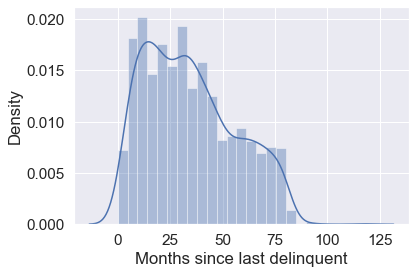

In [2492]:
sns.distplot(tmp_months_since_last_target_0);

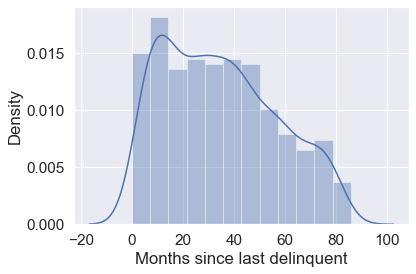

In [2493]:
sns.distplot(tmp_months_since_last_target_1);

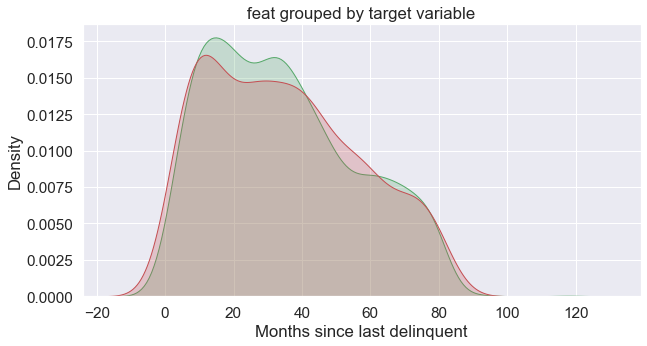

In [2494]:
#feat = 'Months since last delinquent'

plt.figure(figsize=(10, 5))

sns.kdeplot(tmp_months_since_last_target_0, shade=True, label='No default', color='g')
sns.kdeplot(tmp_months_since_last_target_1, shade=True, label='Default', color='r')

plt.xlabel(feat)
plt.title('feat grouped by target variable');

In [2495]:
stat, p = shapiro(df_feat[feat])
p

5.908039779407961e-31

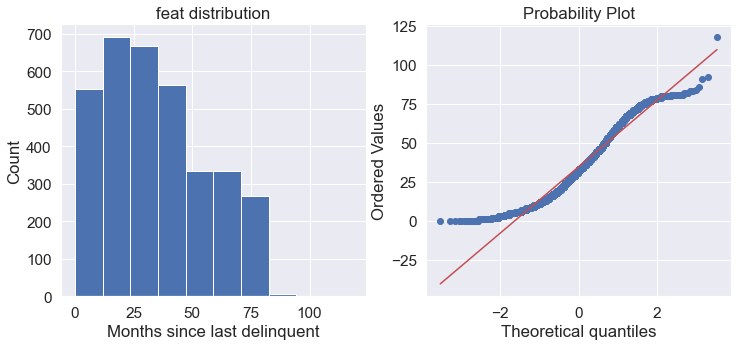

In [2496]:
plt.figure(figsize=(12, 5))

ax1 = plt.subplot(121)
ax1.set_xlabel(feat)
ax1.set_ylabel('Count')
ax1.set_title('feat distribution')
df_feat[feat].hist()

plt.subplot(122)
probplot(df_feat[feat], dist='norm', plot=plt);

In [2497]:
stat, p = mannwhitneyu(tmp_months_since_last_target_0, tmp_months_since_last_target_1)
p

0.4996029076417083

Гипотеза о равности мат. ожиданий подтверждается. Построим доверительные интервалы.

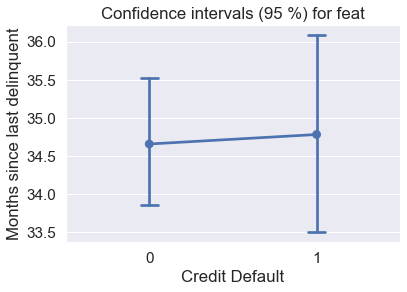

In [2498]:
sns.pointplot(x=target_name, y=feat, data=df_feat, capsize=.1)
plt.title('Confidence intervals (95 %) for feat');

- интервал "не дефолтной" выборки полностью перекрывается интервалом "дефолтной", что говорит о слабости признака в предсказании поведения целевой.

Учитываю вышесказанное, а также тот факт, что изначально в признаке 'Months since last delinquent' отсутствуют значения больше половины выборки прихожу к выводу о нецелесообразности искать варианты заполнения отсутствующих значений. Целесообразней будет удалить данный признак из дальнейших исследований.

In [2499]:
# df_train = df_train.drop('Months since last delinquent', axis=1)
# tmp_no_credit_default = tmp_no_credit_default.drop('Months since last delinquent', axis=1)
# tmp_credit_default = tmp_credit_default.drop('Months since last delinquent', axis=1)

In [2500]:
# df_train.isna().sum()

### признак 'Credit Score'

- признак 'Credit Score' в исходном датасете имеет такое же кол-во пропусков, как и признак 'Annual Income'. Ранее я сделал предположение о взаимосвязи по этой причине этих признаков. Пропуски в признаке 'Annual Income' я закрывал используя группы в признаке 'Purpose' (цели кредита), этим же методом (учитывая их "родовую" зависимость) я планирую закрыть пропуски и в этом признаке, но для пущей верности посмотрим на этот признак со стороны других признаков с целью найти влияние сильней.

In [2501]:
feat = 'Credit Score'

In [2502]:
# df_train[feat].value_counts()

- создам временный датасет, где изучаемый признак не имеет пропусков.

In [2503]:
# tmp_credit_score = df_train.loc[df_train[feat].isna() != True]
# tmp_credit_score.head()

- на его основе создам датасет из количественных признаков для построения гистограмм.

In [2504]:
# df_num_features = tmp_credit_score.select_dtypes(include=['float64', 'float32', 'float16'])
# df_num_features.head()

In [2505]:
# df_num_features.hist(figsize=(16, 16), bins=20, grid=False);

- сделаю те же операции для данных где изучаемы признак имеет значения Nan.

In [2506]:
# tmp_credit_score_nan = df_train.loc[df_train[feat].isna() == True]
# tmp_credit_score_nan.head()

In [2507]:
# df_num_features_nan = tmp_credit_score_nan.select_dtypes(include=['float64', 'float32', 'float16'])
# df_num_features_nan.head()

In [2508]:
# df_num_features_nan.hist(figsize=(16, 16), bins=20, grid=False);

In [2509]:
# df_num_features.describe()

In [2510]:
# df_num_features_nan.describe()

- Изучая попарно значения квартилей из последних двух таблиц и изучив гистограммы распределений признаков делаю вывод о "слабости" влияния количественных признаков на признак 'Credit Score', поэтому возвращаюсь к заполнению пропусков таким же образом как я делал в признаке 'Annual Income'.

In [2511]:
# df_cat_purpose_score = df_train.groupby('Purpose', as_index=False).median()[['Purpose', 'Credit Score']]
# df_cat_purpose_score = pd.DataFrame(df_cat_purpose_score)

# df_cat_purpose_score

In [2512]:
# median = df_cat_purpose_score['Credit Score'].median()
# median

In [2513]:
# df_cat_purpose_score['Credit Score'] = df_cat_purpose_score['Credit Score'].fillna(median)
# df_cat_purpose_score

In [2514]:
# df_cat_purpose_score.rename(columns={'Credit Score' : 'median_purpose_score'}, inplace=True)
# df_cat_purpose_score.sort_values(by='median_purpose_score')

In [2515]:
# df_train = df_train.merge(df_cat_purpose_score, on=['Purpose'])
# df_train.head()

In [2516]:
# df_train['Credit Score'] = df_train['Credit Score'].fillna(df_train['median_purpose_score'])

In [2517]:
df_train['Credit Score'].isna().value_counts()

False    5943
True     1557
Name: Credit Score, dtype: int64

- проверяю на предмет наличия пропусков

In [2518]:
# df_train.isna().sum()

- Задача решена. Двигаюсь дальше.

### Рассмотрю влияние признаков на целевую переменную

- признак 'Current Loan Amount'

- Буду рассматривать два датасета - "дефолтный" и "не дефлотный".

In [2519]:
# tmp_no_credit_default['Current Loan Amount'].describe()

Выведем такие же статистики для дефолтного датасета

In [2520]:
# tmp_credit_default['Current Loan Amount'].describe()

- квартильные значения в "не дефолтном" датасете значительно превышают аналогичные показатели в "дефолтном", что может сигнализировать о важности признака на предмет влияния на целевую переменную.

In [2521]:
# plt.hist(tmp_credit_default['Current Loan Amount'], bins=50)

In [2522]:
# plt.hist(tmp_no_credit_default['Current Loan Amount'], bins=50)

In [2523]:
mean_cla_def = np.mean(tmp_credit_default['Current Loan Amount'])
mean_cla_no_def = np.mean(tmp_no_credit_default['Current Loan Amount'])

mean_cla_def, mean_cla_no_def

(326651.0440132513, 16402193.648041582)

Получили датасет с наличием "выбросов" с левой стороны, что делает его "дальше" от нормального распределения. Создадим временный датасет исключив эти аномальные данные с целью изучения влияния этого признака на целевую переменную.

In [2524]:
tmp_no_cr_def = tmp_no_credit_default.loc[tmp_no_credit_default['Current Loan Amount'] > 0]
tmp_no_cr_def.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0


(array([4517.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,  870.]),
 array([1.12420000e+04, 2.01101714e+06, 4.01079228e+06, 6.01056742e+06,
        8.01034256e+06, 1.00101177e+07, 1.20098928e+07, 1.40096680e+07,
        1.60094431e+07, 1.80092183e+07, 2.00089934e+07, 2.20087685e+07,
        2.40085437e+07, 2.60083188e+07, 2.80080940e+07, 3.00078691e+07,
        3.20076442e+07, 3.40074194e+07, 3.60071945e+07, 3.80069697e+07,
        4.00067448e+07, 4.20065199e+07, 4.40062951e+07, 4.60060702e+07,
        4.80058454e+07, 5.00056205e+07, 5.20053956e+07, 5.40051708e+07,
        5.60049459e+07, 5.80047211e+07, 6.00044962e+07, 6.20042713e+07,
        6.40040465e+07, 

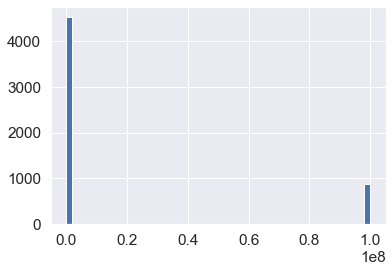

In [2525]:
plt.hist(tmp_no_cr_def['Current Loan Amount'], bins=50)

Имеем два распределения признака 'Current Loan Amount' по целевой переменной. Проверим верность нулевой гипотезы о равенстве средних этих двух распределений, применив критерий Стьюдента, но для этого необходимо проверить выборки на нормальность. Проверим распределения на "нормальность" применяя критерий Шапиро-Уилка. 

In [2526]:
mean_cla_def = np.mean(tmp_credit_default['Current Loan Amount'])
mean_cla_no_def = np.mean(tmp_no_cr_def['Current Loan Amount'])

mean_cla_def, mean_cla_no_def

(326651.0440132513, 16402193.648041582)

$H_0: \: \mu_1 = \mu_2$<br>
$H_1: \: \mu_1 \ne \mu_2\text{ либо }\mu_1 < \mu_2\text{ либо }\mu_1 > \mu_2$<br>

In [2527]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams.update({'font.size': 14})

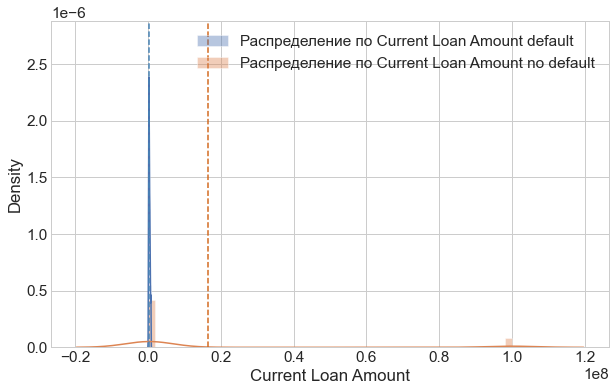

In [2528]:
sns.distplot(tmp_credit_default['Current Loan Amount'], label='Распределение по Current Loan Amount default')
sns.distplot(tmp_no_cr_def['Current Loan Amount'], label='Распределение по Current Loan Amount no default')

plt.axvline(mean_cla_def, color='steelblue', linestyle='--')
plt.axvline(mean_cla_no_def, color='chocolate', linestyle='--')
plt.legend();

In [2529]:
tmp = tmp_no_cr_def['Current Loan Amount'] / 50000
tmp

0       1999.99998
2       1999.99998
3          2.42792
4          2.51680
6       1999.99998
           ...    
7494       5.80800
7495       2.58720
7497    1999.99998
7498      12.30548
7499       0.53856
Name: Current Loan Amount, Length: 5387, dtype: float64

In [2530]:
mu = 10
sigma = 2
N = 4500 # Number of samples

norm_dist = stats.norm(loc=mu, scale=sigma) # Create Random Process
dist_0 = norm_dist.rvs(size=N) # Generate samples

mu_ = np.mean(tmp_no_cr_def['Current Loan Amount'])

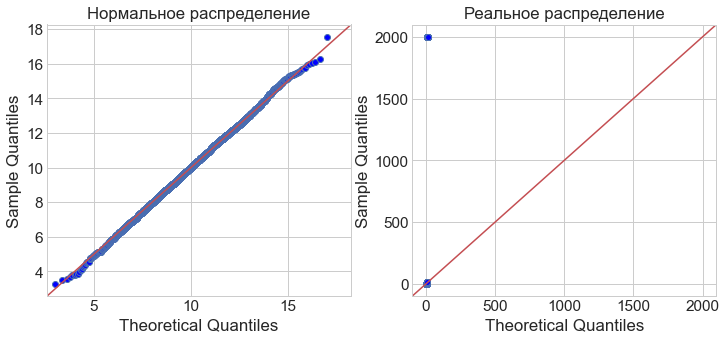

In [2531]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 5))

sm.qqplot(dist_0, line='45', ax=ax0, loc=mu, scale=sigma);
ax0.title.set_text('Нормальное распределение')
sm.qqplot(tmp, line='45', ax=ax1, loc=mu, scale=sigma);
ax1.title.set_text('Реальное распределение')

In [2532]:
stat, p = shapiro(tmp_no_cr_def['Current Loan Amount'])#dist_0
print('W = %.3f, p = %.2E' % (stat, p))
alpha = 0.05
if p > alpha:
    print('✅ Распределение похоже на нормальное (H0 отклонить не можем)')
else:
    print('❌ Распределение на нормальное не похоже (отклоняем H0)')

W = 0.446, p = 0.00E+00
❌ Распределение на нормальное не похоже (отклоняем H0)


- Распределение признака не нормальное, следовательно воспользуемся критерием Манна-Уитни, который не требователен к закону распределения.

- Оценим эквивалентность мат. ожиданий в исследуемых группах с помощью критерия Манна-Уитни*

In [2533]:
stat, p = mannwhitneyu(tmp_no_cr_def['Current Loan Amount'], tmp_credit_default['Current Loan Amount'])
p

2.923443678733522e-10

- делаем вывод: критерий 'Манна-Уитни' подтвердил "не правильность" нулевой гипотезы о равенстве средних этих распределений.

- Построим доверительные интервалы для средних значений каждой из двух групп и сравним их

In [2534]:
df_with_target = df_train[['Current Loan Amount', target_name]].sample(1000)

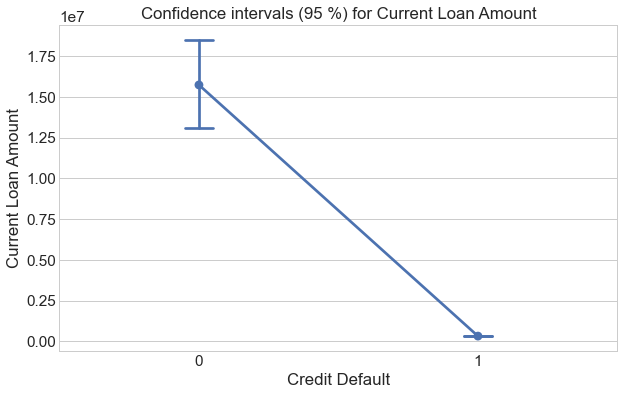

In [2535]:
sns.pointplot(x='Credit Default', y='Current Loan Amount', data=df_with_target, capsize=.1)
plt.title('Confidence intervals (95 %) for Current Loan Amount');

По данному графику видим, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания дефолтного и не дефолтного датасетов, не пересекаются, что подтверждает результаты, полученные с помощью критерия Манна-Уитни.

Это означает, что группы, из которых взяты данные выборки, с допускаемой нами вероятностью (95%) имеют различные распределения, а значит признак 'Current Loan Amount' полезен для определения значения целевой переменной.

- построим доверительные интервалы для других признаков.

признак - 'Annual Income'

In [2536]:
feat = 'Annual Income'

In [2537]:
df_with_target_feat = df_train[[feat, target_name]]#.sample(1000)

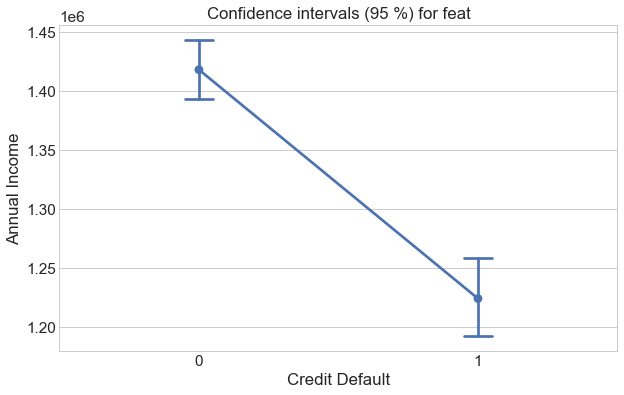

In [2538]:
sns.pointplot(x=target_name, y=feat, data=df_with_target_feat, capsize=.1)
plt.title('Confidence intervals (95 %) for feat');

- доверительные интервалы разведены, что говорит о "полезности" признака 'Annual Income'.

признак - 'Monthly Debt'

In [2539]:
df_with_target_feat = df_train[['Monthly Debt', target_name]]#.sample(1000)

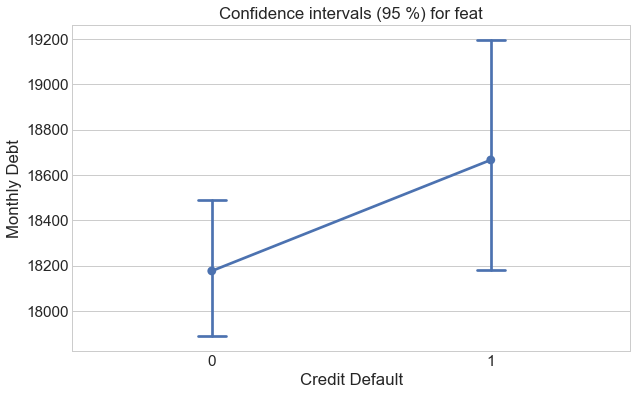

In [2540]:
sns.pointplot(x=target_name, y='Monthly Debt', data=df_with_target_feat, capsize=.1)
plt.title('Confidence intervals (95 %) for feat');

- в признаке есть потенциал

признак - 'Maximum Open Credit'

In [2541]:
df_with_target_feat = df_train[['Maximum Open Credit', target_name]]#.sample(1000)

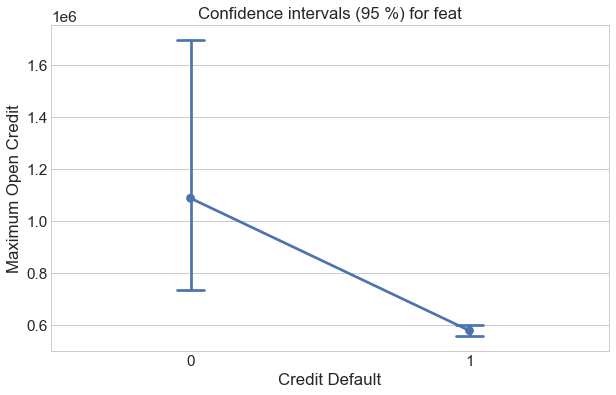

In [2542]:
sns.pointplot(x=target_name, y='Maximum Open Credit', data=df_with_target_feat, capsize=.1)
plt.title('Confidence intervals (95 %) for feat');

- доверительные интервалы разведены, что говорит о "полезности" признака 'Maximum Open Credit'.

признак - 'Current Credit Balance'

In [2543]:
df_with_target_feat = df_train[['Current Credit Balance', target_name]]#.sample(1000)

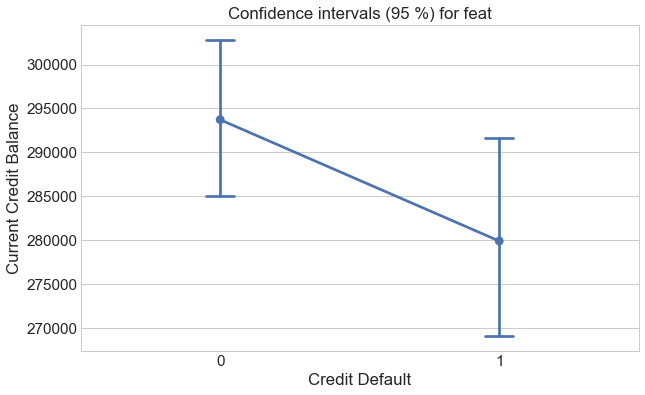

In [2544]:
sns.pointplot(x=target_name, y='Current Credit Balance', data=df_with_target_feat, capsize=.1)
plt.title('Confidence intervals (95 %) for feat');

In [2545]:
df_with_target_feat = df_train[['Credit Score', target_name]]#.sample(1000)

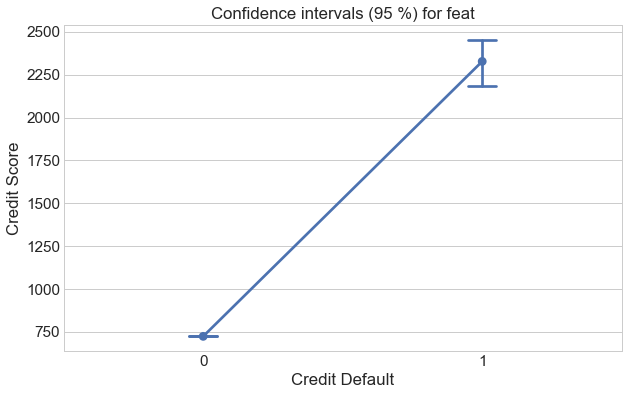

In [2546]:
sns.pointplot(x=target_name, y='Credit Score', data=df_with_target_feat, capsize=.1)
plt.title('Confidence intervals (95 %) for feat');

In [2547]:
df_with_target_feat = df_train[['Term', target_name]]#.sample(1000)

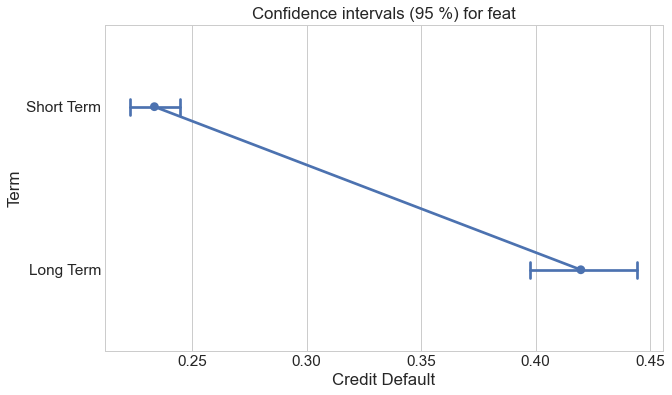

In [2548]:
sns.pointplot(x=target_name, y='Term', data=df_with_target_feat, capsize=.1)
plt.title('Confidence intervals (95 %) for feat');

In [2549]:
df_with_target_feat = df_train[['Years in current job', target_name]]#.sample(1000)

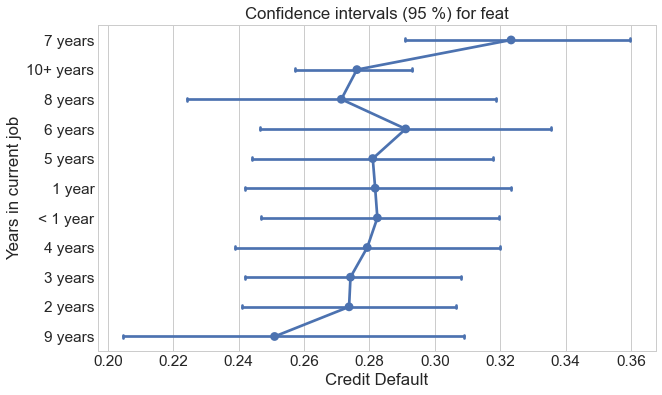

In [2550]:
sns.pointplot(x=target_name, y='Years in current job', data=df_with_target_feat, capsize=.1)
plt.title('Confidence intervals (95 %) for feat');

- полезные признаки - 'Current Loan Amount', 'Annual Income', 'Term', 'Credit Score'
- с хорошим потенциалом - 'Maximum Open Credit', 'Current Credit Balance', 'Monthly Debt'

## Анализ целевой переменной

- изучим воздействие признаков на целевую переменную

### Колличественные признаки

#### признак 'Years of Credit History'

In [2551]:
# plt.figure(figsize=(16, 8))

# sns.violinplot(df_train['Credit Default'], df_train['Years of Credit History'], whis=1.5)

# plt.xlabel('Credit Default')
# plt.ylabel('Years of Credit History')
# plt.title('Distribution of median_house_value by Years of Credit History')
# plt.show()

- распределение признака по этой группе практически единтичны.

#### признак 'Credit Score'

In [2552]:
# sns.violinplot(df_train['Credit Default'], df_train['Credit Score'], whis=1.5)

# plt.xlabel('Credit Default')
# plt.ylabel('Credit Score')
# plt.title('Distribution of median_house_value by Credit Score')
# plt.show()

In [2553]:
# sns.boxplot(x='Credit Default', y='Credit Score', data=df_train)

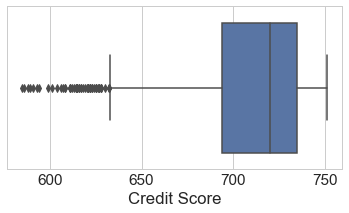

In [2554]:
plt.figure(figsize=(6, 3))

sns.boxplot(tmp_credit_default['Credit Score'], whis=1.5)

plt.xlabel('Credit Score')
plt.show()

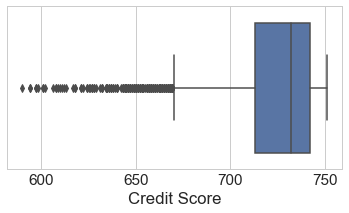

In [2555]:
plt.figure(figsize=(6, 3))

sns.boxplot(tmp_no_credit_default['Credit Score'], whis=1.5)

plt.xlabel('Credit Score')
plt.show()

- В "нулевой" группе видно поджатие к верхним значениям, напротив в "первой" группе плотность ненамного, но ниже и не видно этого поджатия вверх, наоборот видна "слабость", как-будто сейчас сползет вниз к нижним значениям.

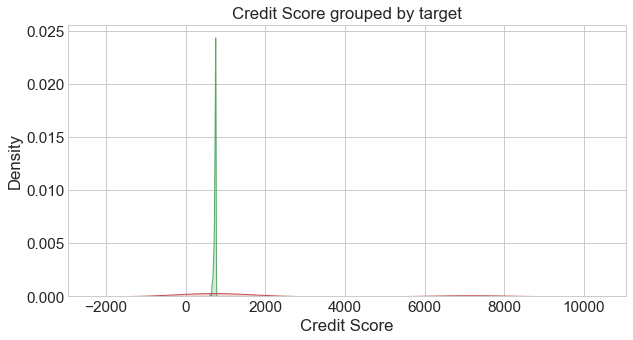

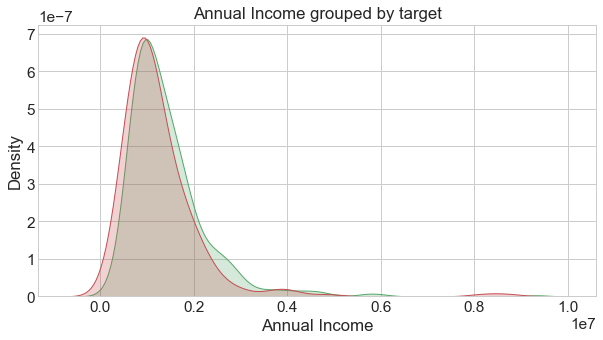

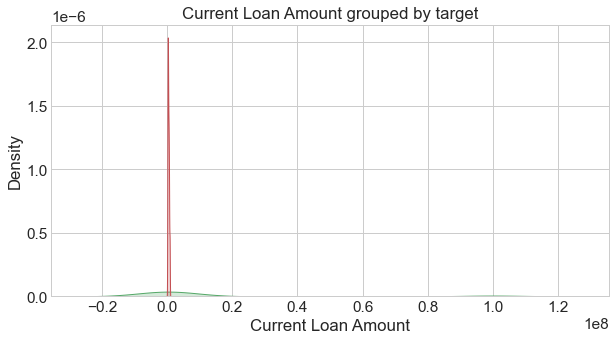

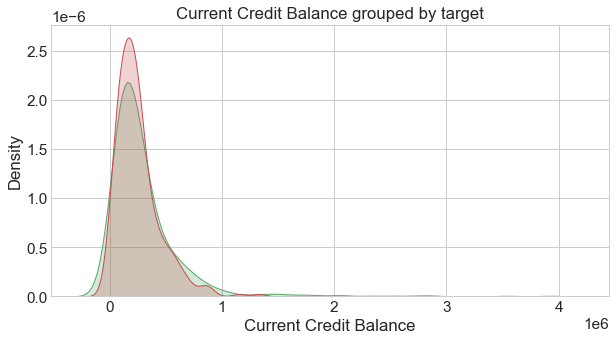

In [2556]:
for feature in ['Credit Score', 'Annual Income', 'Current Loan Amount', 'Current Credit Balance']:
    feature_with_target = df_train[[feature, target_name]].sample(1000)
    feature_sample = feature_with_target[feature]
    feature_with_target_0 = feature_sample[feature_with_target[target_name] == 0]
    feature_with_target_1 = feature_sample[feature_with_target[target_name] == 1]
    
    plt.figure(figsize=(10, 5))

    sns.kdeplot(feature_with_target_0, shade=True, label='No default', color='g')
    sns.kdeplot(feature_with_target_1, shade=True, label='Default', color='r')

    plt.xlabel(feature)
    plt.title(feature + ' grouped by target');

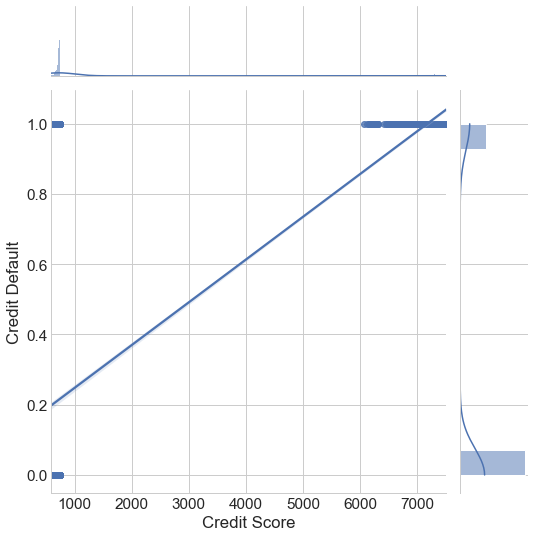

In [2557]:
grid = sns.jointplot(df_train['Credit Score'], df_train['Credit Default'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

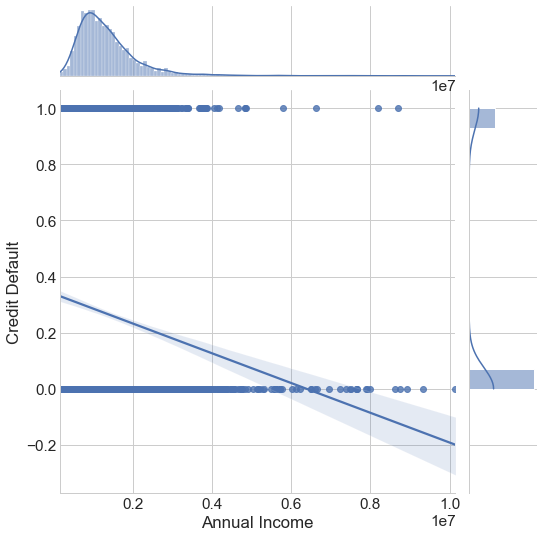

In [2558]:
grid = sns.jointplot(df_train['Annual Income'], df_train['Credit Default'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

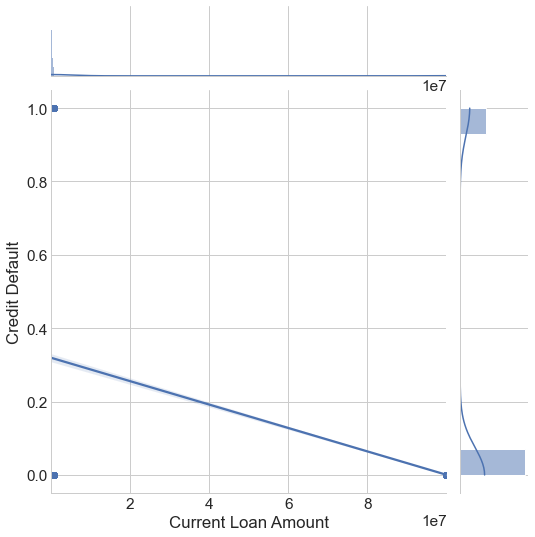

In [2559]:
grid = sns.jointplot(df_train['Current Loan Amount'], df_train['Credit Default'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

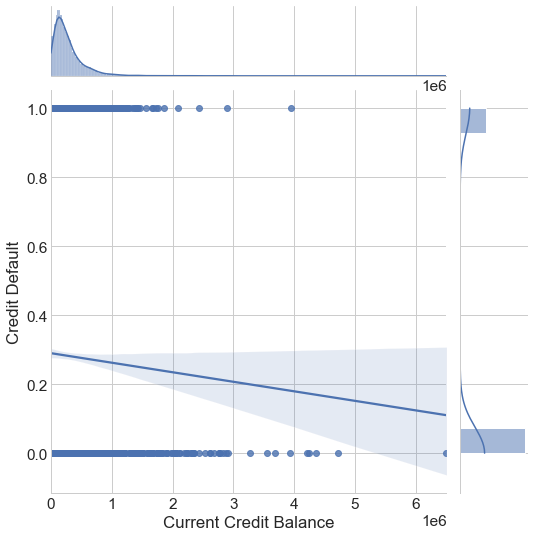

In [2560]:
grid = sns.jointplot(df_train['Current Credit Balance'], df_train['Credit Default'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

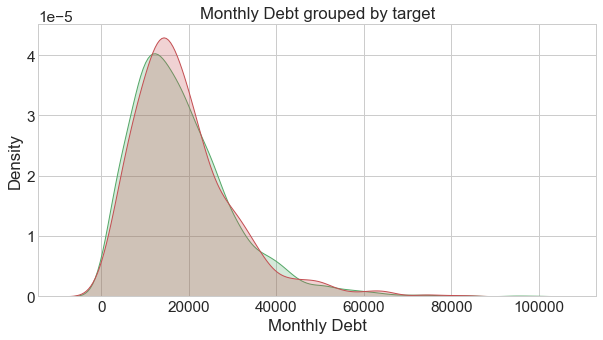

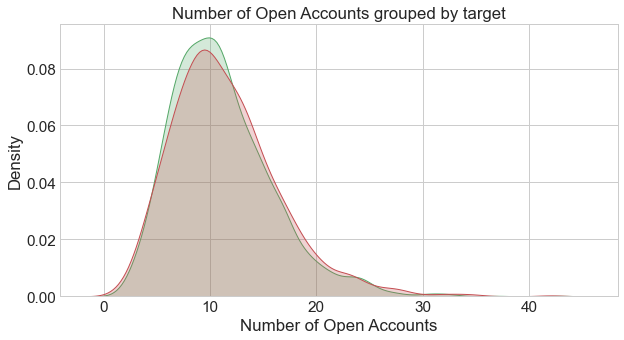

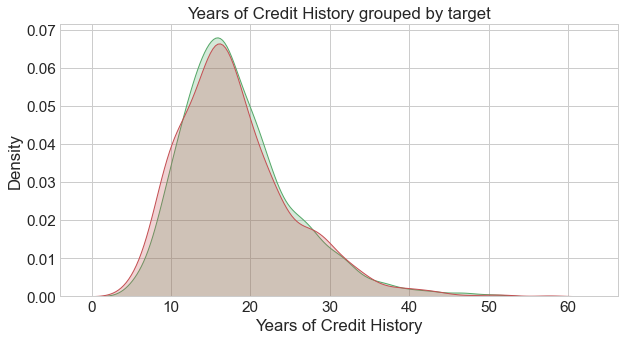

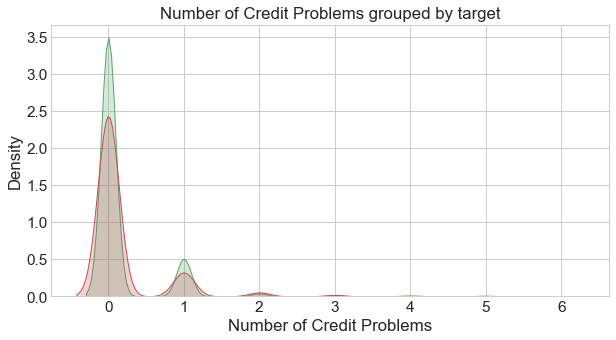

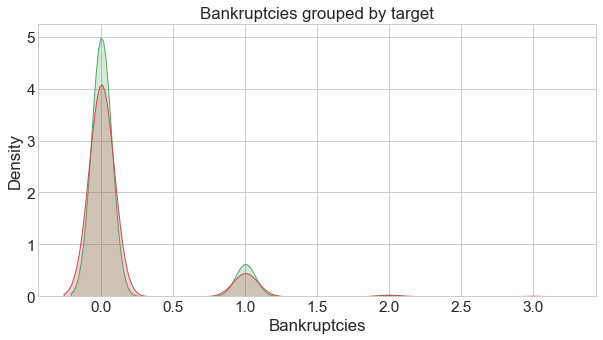

In [2561]:
for feature in ['Monthly Debt', 'Number of Open Accounts', 'Years of Credit History', 'Number of Credit Problems',
               'Bankruptcies']:
    feature_with_target = df_train[[feature, target_name]].sample(4000)
    feature_sample = feature_with_target[feature]
    feature_with_target_0 = feature_sample[feature_with_target[target_name] == 0]
    feature_with_target_1 = feature_sample[feature_with_target[target_name] == 1]
    
    plt.figure(figsize=(10, 5))

    sns.kdeplot(feature_with_target_0, shade=True, label='No default', color='g')
    sns.kdeplot(feature_with_target_1, shade=True, label='Default', color='r')

    plt.xlabel(feature)
    plt.title(feature + ' grouped by target');

В признаках 'Monthly Debt', 'Number of Open Accounts', 'Years of Credit History' распределения в "дефолтном" и "не дефолтном" датасете практически совпадают, что даёт основание утверждать о равенстве средних значений и можно с большой долей уверенности сказать о слабости этих признаков в предсказании таргета. 

### Категориальные признаки

#### признак 'Term'

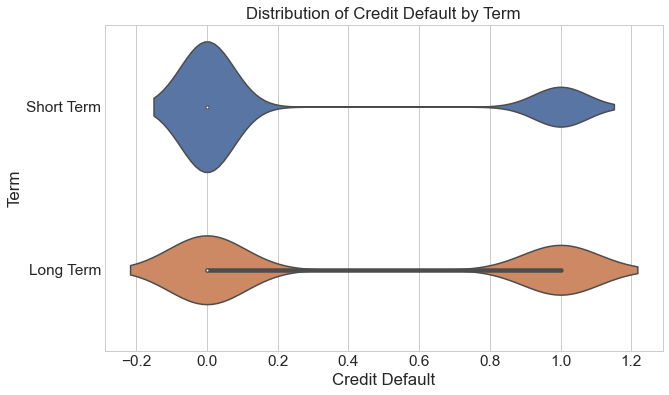

In [2562]:
sns.violinplot(df_train['Credit Default'], df_train['Term'], whis=1.5)

plt.xlabel('Credit Default')
plt.ylabel('Term')
plt.title('Distribution of Credit Default by Term')
plt.show()

- В группе 'Long Term' видно равномерность по целевому признаку. Посмотрим подробнее. Оценим признака "Term" в разрезе целевой переменной.

In [2563]:
df_train['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

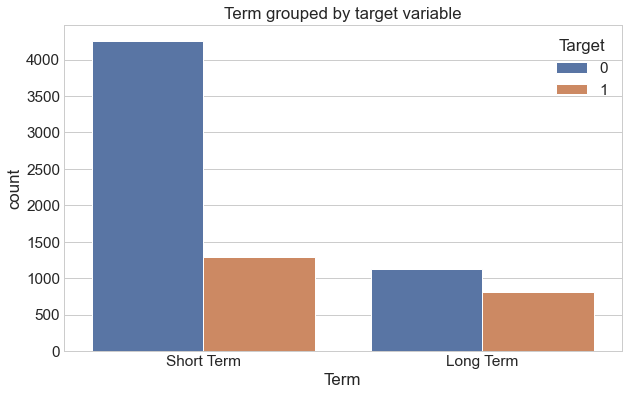

In [2564]:
sns.countplot(x="Term", hue=df_train['Credit Default'], data=df_train)
plt.title('Term grouped by target variable')
plt.legend(title='Target', loc='upper right');

- Из графика вижу, что группа 'Long Term' из признака 'Term' делится практически на две равные части: погасил/ не погасил. Учту этот факт и, создавая на основе этого признака "дамми" признак, присвою группе 'Long Term' значение "0", а группе 'Short Term' значение "1".

#### признак 'Home Ownership'

In [2565]:
# types = df_train['Home Ownership'].value_counts()

In [2566]:
# types = list(types[types.values > 1].index)
# types

In [2567]:
# plt.figure(figsize=(15, 10))

# for b_type in types:
#     subset = df_train[df_train['Home Ownership'] == b_type]
#     sns.kdeplot(subset['Credit Default'],
#                 shade = False, alpha = 0.8, label=b_type);

# plt.xlabel('Credit Default', size = 20); plt.ylabel('Density', size = 20); 
# plt.title('Density Plot of Credit Default by Home Ownership', size = 28);
# plt.legend()

Группа 'Rent' лидирует в "1"-ой группе, меньше всех доля группы 'Have Mortgage'

In [2568]:
# def homeOwnership_to_cat(X):

#     X['homeOwnership_cat'] = 0

#     X.loc[X['Home Ownership'] == 'Rent', 'homeOwnership_cat'] = 1
#     X.loc[X['Home Ownership'] == 'Home Mortgage', 'homeOwnership_cat'] = 2
#     X.loc[X['Home Ownership'] == 'Own Home', 'homeOwnership_cat'] = 3
#     X.loc[X['Home Ownership'] == 'Have Mortgage', 'homeOwnership_cat'] = 4

#     return X

In [2569]:
#df_train = homeOwnership_to_cat(df_train)
#df_train.head()

#### признак 'Home Ownership'

In [2570]:
# types = df_train['Purpose'].value_counts()
# types = list(types[types.values > 1].index)

In [2571]:
# plt.figure(figsize=(15, 10))

# for b_type in types:
#     subset = df_train[df_train['Purpose'] == b_type]
#     sns.kdeplot(subset['Credit Default'],
#                 shade = False, alpha = 0.8, label=b_type);

# plt.xlabel('Credit Default', size = 20); plt.ylabel('Density', size = 20); 
# plt.title('Density Plot of Credit Default by Purpose', size = 28);
# plt.legend()

In [2572]:
# plt.figure(figsize=(15, 20))
# sns.violinplot(df_train['Credit Default'], df_train['Purpose'], whis=1.5)

# plt.xlabel('Credit Default')
# plt.ylabel('Purpose')
# plt.title('Distribution of Credit Default by Purpose')
# plt.show()

Из графика плотности распределния вижу, что следующие категории признака 'Purpose', а имеенно: 'small business' (сильно "слабее" других категорий - плотность в "1"-ой группе выше чем в "0"-ой), чуть получше в группе 'business loan'. Менее всего в "1"-ую группу добавляют признаки 'educational expenses' и 'moving'.

- Категориальные признаки содержат категории сильно слабее или сильно лучше других, поэтому попробую, хоть и ввёл на их основе "дамми" признаки, всё же оставить их переведя значения в числовые группы. Числа группам присвою на основе графика сверху вниз от 0 до большего значения.

In [2573]:
# def purpose_to_cat(X):

#     X['purpose_cat'] = 0

#     X.loc[X['Purpose'] == 'renewable energy', 'purpose_cat'] = 1
#     X.loc[X['Purpose'] == 'debt consolidation', 'purpose_cat'] = 2
#     X.loc[X['Purpose'] == 'other', 'purpose_cat'] = 3
#     X.loc[X['Purpose'] == 'business loan', 'purpose_cat'] = 4
#     X.loc[X['Purpose'] == 'small business', 'purpose_cat'] = 5
#     X.loc[X['Purpose'] == 'home improvements', 'purpose_cat'] = 6
#     X.loc[X['Purpose'] == 'medical bills', 'purpose_cat'] = 7  
#     X.loc[X['Purpose'] == 'buy a car', 'purpose_cat'] = 8
#     X.loc[X['Purpose'] == 'take a trip', 'purpose_cat'] = 9
#     X.loc[X['Purpose'] == 'buy house', 'purpose_cat'] = 10
#     X.loc[X['Purpose'] == 'major purchase', 'purpose_cat'] = 11
#     X.loc[X['Purpose'] == 'wedding', 'purpose_cat'] = 12
#     X.loc[X['Purpose'] == 'vacation', 'purpose_cat'] = 13
#     X.loc[X['Purpose'] == 'moving', 'purpose_cat'] = 14
#     X.loc[X['Purpose'] == 'educational expenses', 'purpose_cat'] = 15

#     return X

In [2574]:
#df_train = purpose_to_cat(df_train)
#df_train.head()

#### признак 'Years in current job'

In [2575]:
# types = df_train['Years in current job'].value_counts()
# types = list(types[types.values > 1].index)

In [2576]:
# plt.figure(figsize=(15, 10))

# for b_type in types:
#     subset = df_train[df_train['Years in current job'] == b_type]
#     sns.kdeplot(subset['Credit Default'],
#                 shade = False, alpha = 0.8, label=b_type);

# plt.xlabel('Credit Default', size = 20); plt.ylabel('Density', size = 20); 
# plt.title('Density Plot of Credit Default by Years in current job', size = 28);
# plt.legend()

In [2577]:
# plt.figure(figsize=(15, 15))
# sns.violinplot(df_train['Credit Default'], df_train['Years in current job'], whis=1.5)

# plt.xlabel('Credit Default')
# plt.ylabel('Years in current job')
# plt.title('Distribution of Credit Default by "Years in current job"')
# plt.show()

In [2578]:
# def yearsInCurrentJob_to_cat(X):

#     X['years_job_cat'] = 0

#     X.loc[X['Years in current job'] == '10+ years', 'years_job_cat'] = 1
#     X.loc[X['Years in current job'] == '< 1 year', 'years_job_cat'] = 2
#     X.loc[X['Years in current job'] == '2 years', 'years_job_cat'] = 3
#     X.loc[X['Years in current job'] == '3 years', 'years_job_cat'] = 4
#     X.loc[X['Years in current job'] == '1 years', 'years_job_cat'] = 5
#     X.loc[X['Years in current job'] == '6 years', 'years_job_cat'] = 6
#     X.loc[X['Years in current job'] == '4 years', 'years_job_cat'] = 7  
#     X.loc[X['Years in current job'] == '5 years', 'years_job_cat'] = 8
#     X.loc[X['Years in current job'] == '7 years', 'years_job_cat'] = 9
#     X.loc[X['Years in current job'] == '8 years', 'years_job_cat'] = 10
#     X.loc[X['Years in current job'] == '9 years', 'years_job_cat'] = 11

#     return X

In [2579]:
#df_train = yearsInCurrentJob_to_cat(df_train)
#df_train.head()

In [2580]:
#PREP_DATASET_PATH = 'data/training_project_data_prep.csv'

На основе полезных признаков, комбинируя их создам дополнительные полезные признаки.

### Построение новых признаков

построю таблицу корреляции, чтобы посмотреть на основе каких признаках можно комбинируя создать новые полезные признаки.

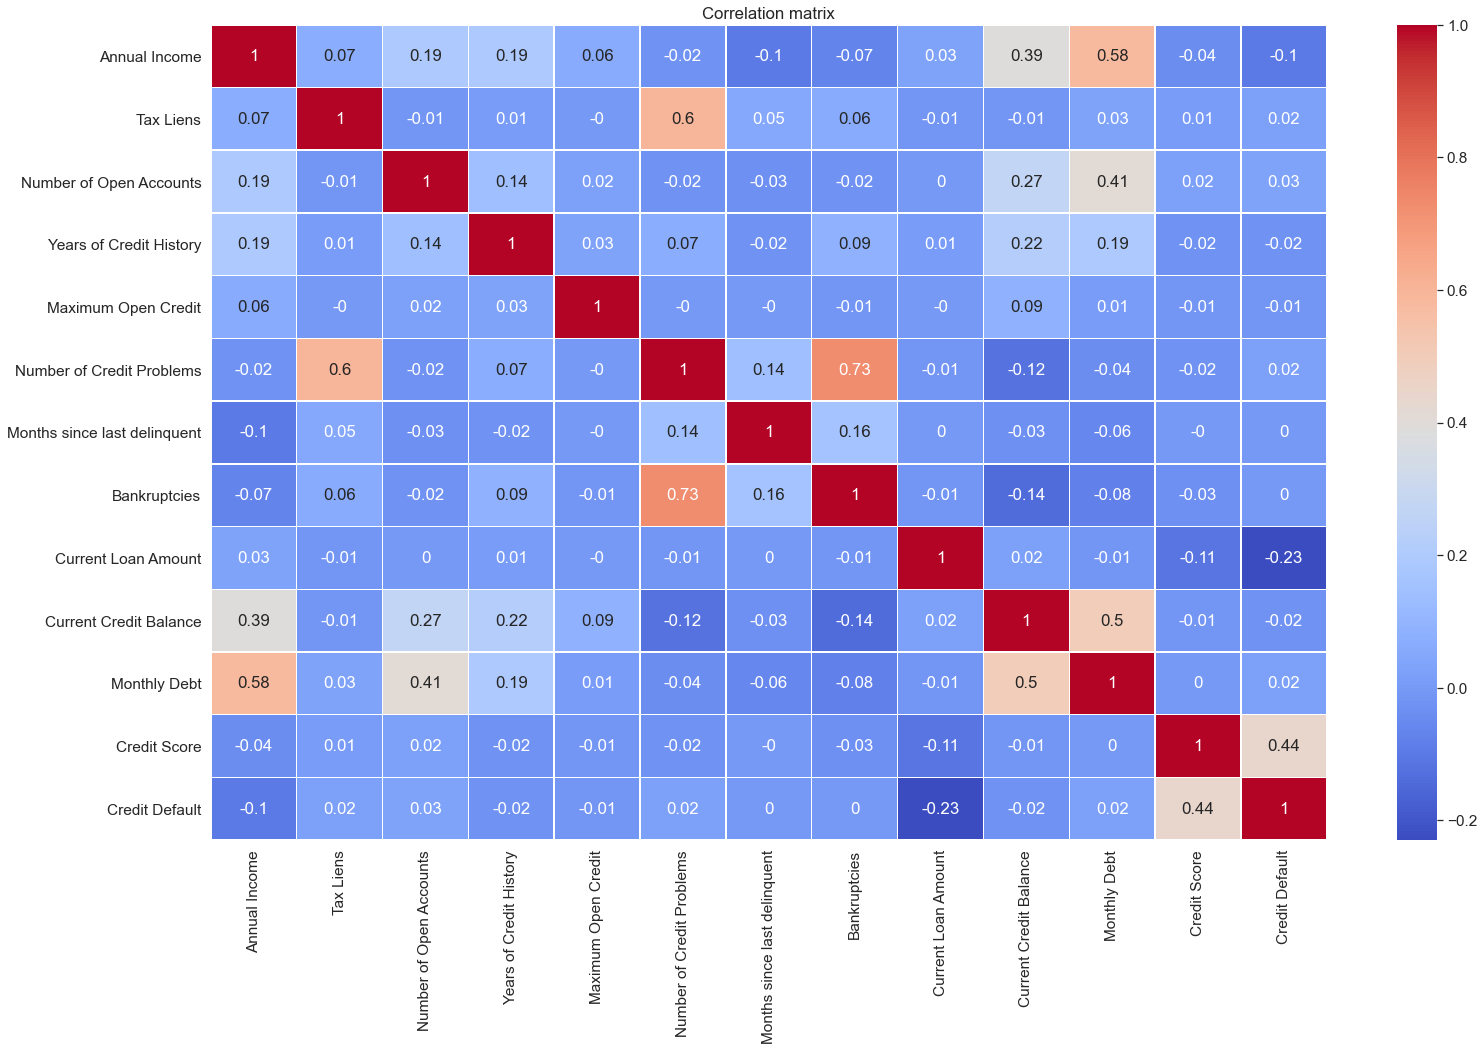

In [2581]:
plt.figure(figsize=(25, 15))

sns.set(font_scale=1.4)

corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
#corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Не так много признаков имееют корреляцию с таргетом, лишь два признака 'Credit Score' и 'Current Loan Amount' имеют какое-то воздействие на неё. Буду строить новые признаки задействуя эти два признака.

### Количественные переменные

- Построю новые признаки на основе экономических взаимосвязей или просто проводя над признаками математические действия.

Рассмотрю построение нового признака на основе отношения: 'Monthly Debt' / 'Credit Score'. Построю распределения. Экономического объяснения это отношение не имеет, лишь связывает два признака имеющих влияние на таргет.

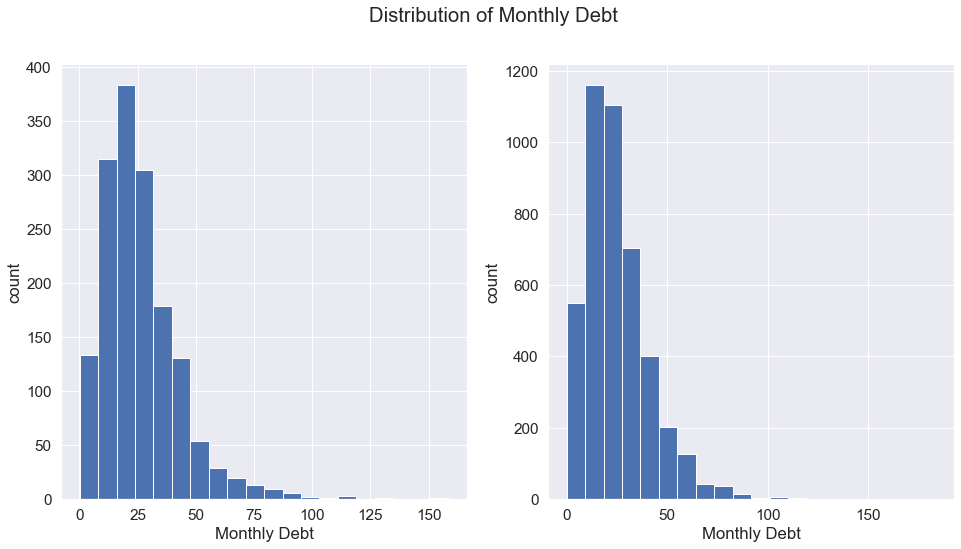

In [2582]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
(tmp_credit_default['Monthly Debt'] / tmp_credit_default['Credit Score']).hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('Monthly Debt')

plt.subplot(122)
(tmp_no_credit_default['Monthly Debt'] / tmp_no_credit_default['Credit Score']).hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('Monthly Debt')

plt.suptitle('Distribution of Monthly Debt')
plt.show()

Результат (значения) в "дефолтном" в разы меньше чем в "не дефолтном" датасете.

In [2583]:
df_train['credit_score_in_monthly_debt'] = df_train['Monthly Debt'] / df_train['Credit Score']
df_test['credit_score_in_monthly_debt'] = df_test['Monthly Debt'] / df_test['Credit Score']

- введу новый признак характеризующий доход клиента в месяц.

In [2584]:
df_train['monthly_income'] = df_train['Annual Income'] / 12
df_test['monthly_income'] = df_test['Annual Income'] / 12

- введу новый признак характеризующий чистый долг клиента.

In [2585]:
df_train['net_debt'] = df_train['Current Loan Amount'] - df_train['Annual Income']
df_test['net_debt'] = df_test['Current Loan Amount'] - df_test['Annual Income']

- новый признак - сколько "кредита" в годовом доходе.

In [2586]:
df_train['credit_in_income'] = df_train['Current Loan Amount'] / df_train['Annual Income']
df_test['credit_in_income'] = df_test['Current Loan Amount'] / df_test['Annual Income']

- новый признак - доля платежей по году в годовом доходе

In [2587]:
df_train['share_credit_in_income'] = df_train['Monthly Debt'] * 12 / df_train['Annual Income']
df_test['share_credit_in_income'] = df_test['Monthly Debt'] * 12 / df_test['Annual Income'] 

- новый признак на основе размера "группы" по цели кредита.

### Feature encoding

In [2588]:
# group_size_purpose = df_train['Purpose'].value_counts().reset_index()\
#                     .rename(columns={'index':'Purpose', 'Purpose':'groupSizePurpose'})

# group_size_purpose.head(11)

In [2589]:
#df_train = df_train.merge(group_size_purpose, on='Purpose', how='left')

- новый признак на основе размера "группы" по домовладению.

In [2590]:
# group_size_home_ownership = df_train['Home Ownership'].value_counts().reset_index()\
#                     .rename(columns={'index':'Home Ownership', 'Home Ownership':'groupSizeHomeOwnership'})

# group_size_home_ownership.head()

- делаю левое слияние

In [2591]:
#df_train = df_train.merge(group_size_home_ownership, on='Home Ownership', how='left')

- новый признак на основе размера "группы" по кол-ву лет на текущем месте работы.

In [2592]:
# group_size_YinСjob = df_train['Years in current job'].value_counts().reset_index()\
#                     .rename(columns={'index':'Years in current job', 'Years in current job':'groupSizeYearsInCurrentJob'})

# group_size_YinСjob.head()

In [2593]:
#df_train = df_train.merge(group_size_YinСjob, on='Years in current job', how='left')

In [2594]:
# group_size_tax_liens = df_train['Tax Liens'].value_counts().reset_index()\
#                     .rename(columns={'index':'Tax Liens', 'Tax Liens':'groupSizeTaxLiens'})

# group_size_tax_liens.head()

In [2595]:
#df_train = df_train.merge(group_size_tax_liens, on='Tax Liens', how='left')

In [2596]:
# group_size_YearsOfCreditHistory = df_train['Years of Credit History'].value_counts().reset_index()\
#                     .rename(columns={'index':'Years of Credit History', 'Years of Credit History':'grSizeYearsOfCreditHistory'})

# group_size_YearsOfCreditHistory.head()

In [2597]:
#df_train = df_train.merge(group_size_YearsOfCreditHistory, on='Years of Credit History', how='left')

In [2598]:
# group_size_NumberOfCreditProblems = df_train['Number of Credit Problems'].value_counts().reset_index()\
#                     .rename(columns={'index':'Number of Credit Problems', 'Number of Credit Problems':'grSizeNumberOfCreditProblems'})

# group_size_NumberOfCreditProblems.head()

In [2599]:
#df_train = df_train.merge(group_size_NumberOfCreditProblems, on='Number of Credit Problems', how='left')

In [2600]:
# group_size_Bankruptcies = df_train['Bankruptcies'].value_counts().reset_index()\
#                     .rename(columns={'index':'Bankruptcies', 'Bankruptcies':'groupSizeBankruptcies'})

# group_size_Bankruptcies.head()

In [2601]:
#df_train = df_train.merge(group_size_Bankruptcies, on='Bankruptcies', how='left')

In [2602]:
group_size_CreditScore = df_train['Credit Score'].value_counts().reset_index()\
                    .rename(columns={'index':'Credit Score', 'Credit Score':'groupSizeCreditScore'})

group_size_CreditScore.head()

,Credit Score,groupSizeCreditScore
0,740.0,169
1,747.0,168
2,748.0,157
3,745.0,152
4,742.0,151


In [2603]:
group_size_CreditScore_test = df_test['Credit Score'].value_counts().reset_index()\
                    .rename(columns={'index':'Credit Score', 'Credit Score':'groupSizeCreditScore'})

group_size_CreditScore_test.head()

,Credit Score,groupSizeCreditScore
0,746.0,56
1,739.0,55
2,741.0,54
3,740.0,50
4,747.0,49


In [2604]:
df_train = df_train.merge(group_size_CreditScore, on='Credit Score', how='left')
df_test = df_test.merge(group_size_CreditScore_test, on='Credit Score', how='left')
# df_train.head()

- Выделим числовые признаки, для построения новых. Генерить новые буду применяя к данным математический квадратный корень.

In [2606]:
# numeric_subset = df_train.select_dtypes('number')
#numeric_subset.head()

In [2607]:
# for col in numeric_subset.columns:
#     if col == 'Credit Default':
#         next
#     else:
#         name = 'sqrt ' + col
#         name = name.split()
#         name = '_'.join(name)
#         numeric_subset[name] = np.sqrt(abs(numeric_subset[col]))


#### Dummies переменные

In [2608]:
df_train['is_term'] = df_train['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)
df_test['is_term'] = df_test['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)

In [2609]:
for cat_colname in df_train.select_dtypes(include='object').columns[0:]:
    df_train = pd.concat([df_train, pd.get_dummies(df_train[cat_colname], prefix=cat_colname)], axis=1)
# df_train.head()

In [2610]:
for cat_colname in df_test.select_dtypes(include='object').columns[0:]:
    df_test = pd.concat([df_test, pd.get_dummies(df_test[cat_colname], prefix=cat_colname)], axis=1)
# df_test.head()

In [2613]:
for colname in df_train.columns:
    if (colname not in df_test.columns) & (colname != 'Credit Default'):
        df_test[colname] = 0

In [2615]:
# df_train.rename(columns={'Years in current job_< 1 year':'Years in current job_less 1 year', 
#                          'Years in current job_10+ years': 'Years in current job_more 10 years'}, inplace=True)

In [2616]:
df_train = df_train.drop('Months since last delinquent', axis=1)
df_train = df_train.drop('Years of Credit History', axis=1)
df_train = df_train.drop('Number of Open Accounts', axis=1)

df_test = df_test.drop('Months since last delinquent', axis=1)
df_test = df_test.drop('Years of Credit History', axis=1)
df_test = df_test.drop('Number of Open Accounts', axis=1)

### Подготовка данных

In [2617]:
# class DataPipeline:
#     """Подготовка исходных данных"""
    
#     def __init__(self):
#         """Параметры класса"""
#         self.medians = None
        
#     def fit(self, df):
#         """Сохранение статистик"""
        
#         # Расчет медиан
#         self.medians = df[['', '', '']].median()
        
#     def transform(self, df):
#         """Трансформация данных"""
        
#         # 1. Пропуски
        
#         # 2. Выбросы (outliers)
        
#         # 3. Новые фичи (features)
        
#         # 4. Обработка категорий
        
#         return df

### Отбор признаков

In [2618]:
cat_features_name = ['Home Ownership', 'Years in current job','Purpose', 'Term']

In [2619]:
num_features_name = ['Tax Liens', 'Number of Credit Problems', 'Bankruptcies', 'Annual Income', 'Maximum Open Credit', 
                     'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score',
                     'credit_score_in_monthly_debt', 'monthly_income', 'net_debt', 
                     'credit_in_income', 'share_credit_in_income', 'groupSizeCreditScore',]

In [2620]:
bin_features_name = ['is_term','Home Ownership_Have Mortgage', 'Home Ownership_Home Mortgage', 
                     'Home Ownership_Own Home', 'Home Ownership_Rent','Years in current job_1 year', 
                     'Years in current job_10+ years', 'Years in current job_2 years', 'Years in current job_3 years',
                     'Years in current job_4 years', 'Years in current job_5 years',
                     'Years in current job_6 years', 'Years in current job_7 years',
                     'Years in current job_8 years', 'Years in current job_9 years',
                     'Years in current job_< 1 year', 'Purpose_business loan',
                     'Purpose_buy a car', 'Purpose_buy house', 'Purpose_debt consolidation',
                     'Purpose_educational expenses', 'Purpose_home improvements',
                     'Purpose_major purchase', 'Purpose_medical bills', 'Purpose_moving',
                     'Purpose_other', 'Purpose_renewable energy', 'Purpose_small business',
                     'Purpose_take a trip', 'Purpose_vacation', 'Purpose_wedding',
                     'Term_Long Term', 'Term_Short Term']

In [2621]:
select_features_name = cat_features_name + num_features_name + bin_features_name
print(len(select_features_name))

52


### Стандартизация данных

In [2622]:
scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[num_features_name] = scaler.fit_transform(df_norm[num_features_name])

In [2623]:
stand_features_test = scaler.transform(df_test[num_features_name])

In [2624]:
df_test[num_features_name] = stand_features_test

### Разбиение на train и test

In [2625]:
X = df_norm[select_features_name]
y = df_norm[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=21)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((5625, 52), (1875, 52), (5625,), (1875,))

In [2626]:
df_test = df_test[select_features_name]

### Построение и оценка базовых моделей

In [2627]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

In [2628]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [2629]:
baseline = catb.CatBoostClassifier(iterations=150, 
                                   nan_mode='Min', 
                                   silent=True, 
                                   random_state=21)
baseline.fit(X_train, y_train, 
             cat_features=cat_features_name, 
             eval_set=(X_test, y_test)
            )

y_train_pred = baseline.predict(X_train)
y_test_pred = baseline.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.98      0.87      4046
           1       0.84      0.33      0.47      1579

    accuracy                           0.79      5625
   macro avg       0.82      0.65      0.67      5625
weighted avg       0.80      0.79      0.76      5625

TEST

              precision    recall  f1-score   support

           0       0.77      0.97      0.86      1341
           1       0.78      0.29      0.42       534

    accuracy                           0.77      1875
   macro avg       0.78      0.63      0.64      1875
weighted avg       0.78      0.77      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1299   42
1                381  153


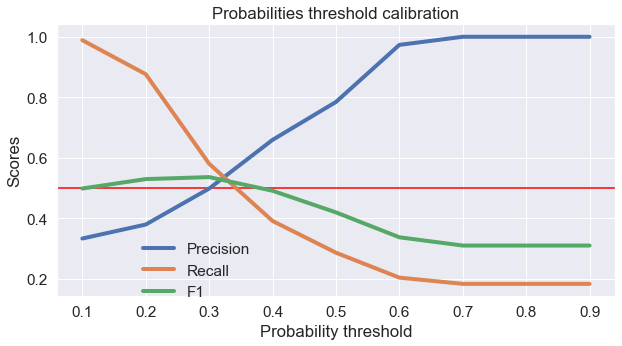

In [2630]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
         
    figure = plt.figure(figsize = (10, 5))

    plt1 = figure.add_subplot(111)
    plt1.axhline(0.5, color="red")
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25));
    
y_test_proba = baseline.predict_proba(X_test)[:, 1]
show_proba_calibration_plots(y_test_proba, y_test)

In [2631]:
y_test_pred = np.array(y_test_proba > 0.3215, dtype=int)
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)


TRAIN

              precision    recall  f1-score   support

           0       0.79      0.98      0.87      4046
           1       0.84      0.33      0.47      1579

    accuracy                           0.79      5625
   macro avg       0.82      0.65      0.67      5625
weighted avg       0.80      0.79      0.76      5625

TEST

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1341
           1       0.54      0.53      0.54       534

    accuracy                           0.74      1875
   macro avg       0.68      0.68      0.68      1875
weighted avg       0.74      0.74      0.74      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1103  238
1                252  282


In [2632]:
baseline.fit(X, y, 
             cat_features=cat_features_name)

In [2633]:
y_test_pred = baseline.predict_proba(df_test)[:, 1]

In [2634]:
y_test_pred = np.array(y_test_pred > 0.3215, dtype=int)

y_test_pred

array([1, 1, 1, ..., 1, 1, 1])